In [13]:
from os import path, walk
from matplotlib import pyplot as plt
from matplotlib import patches
import random as rd
from tqdm import tqdm

In [14]:
DATASET_PATH = "./archive"
ANNOTATIONS_PATH = path.join(DATASET_PATH, "annotations")
IMAGES_PATH = path.join(DATASET_PATH, "images")

## Random Sample

Image shape: (270, 450, 3)


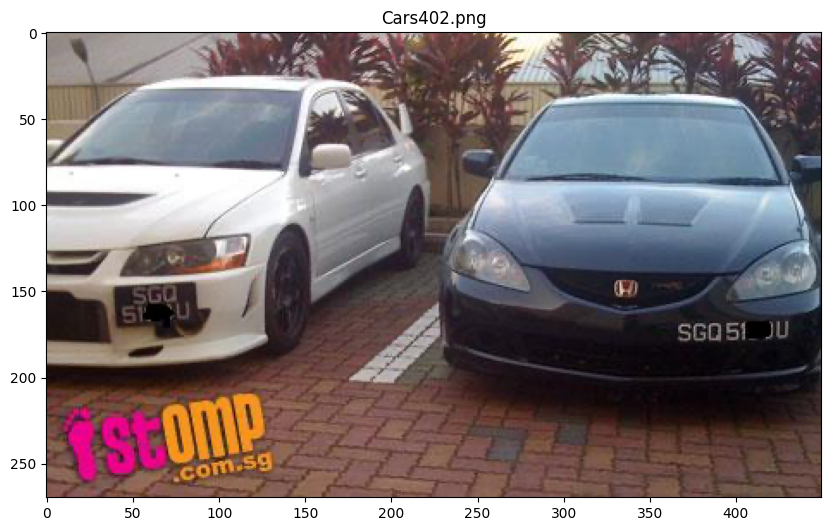

In [15]:
image_filenames = list(walk(IMAGES_PATH))
image_filename = rd.choice(image_filenames[0][2])
image_path = path.join(image_filenames[0][0], image_filename)
img = plt.imread(image_path)
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title(image_filename)
ax.imshow(img)
print('Image shape: {}'.format(img.shape))

In [16]:
annotation = image_filename.split('.')[0] + '.xml'
annotation_path = path.join(ANNOTATIONS_PATH, annotation)
print('Annotation path: {}'.format(annotation_path))

with open(annotation_path, 'r') as f:
    print(f.read())

Annotation path: ./archive/annotations/Cars402.xml

<annotation>
    <folder>images</folder>
    <filename>Cars402.png</filename>
    <size>
        <width>450</width>
        <height>270</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>360</xmin>
            <ymin>165</ymin>
            <xmax>438</xmax>
            <ymax>181</ymax>
        </bndbox>
    </object>
</annotation>


In [17]:
from alprLib.PlateBoundingBox import PlateBoundingBox

plate = PlateBoundingBox(annotation_path)
plate.describe()

PlateBoundingBox
xml_path: ./archive/annotations/Cars402.xml
xmin: 360
ymin: 165
xmax: 438
ymax: 181
width: 78
height: 16
center: (399.0, 173.0)
area: 1248



## Draw Bounding Box on image

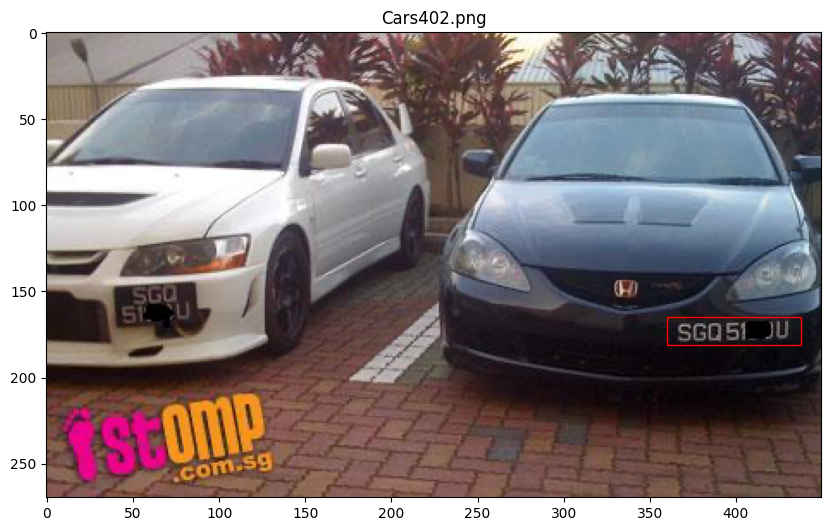

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title(image_filename)
ax.imshow(img)
rect = patches.Rectangle((plate.xmin, plate.ymin), plate.width, plate.height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## Bounding Box extraction

100%|██████████| 433/433 [00:03<00:00, 109.85it/s]


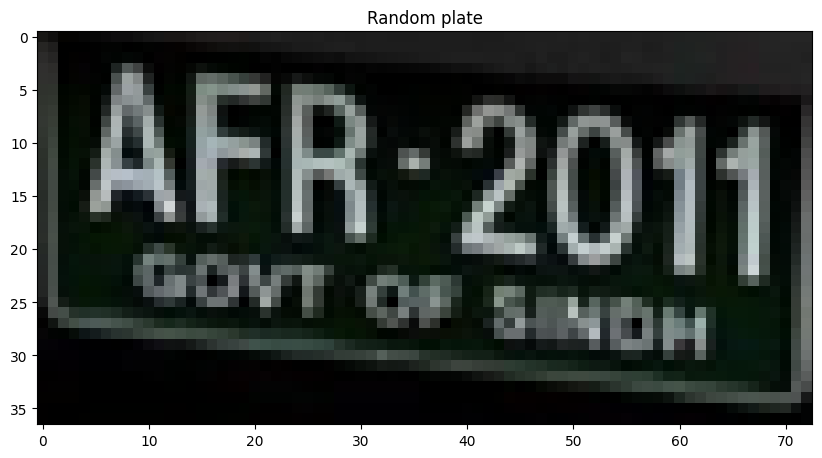

In [19]:
plates = []

image_filenames = list(walk(IMAGES_PATH))
for image_filename in tqdm(image_filenames[0][2]):
    image_path = path.join(image_filenames[0][0], image_filename)
    annotation = image_filename.split('.')[0] + '.xml'
    annotation_path = path.join(ANNOTATIONS_PATH, annotation)
    plate = PlateBoundingBox(annotation_path)
    
    img = plt.imread(image_path)
    plate_img = img[plate.ymin:plate.ymax, plate.xmin:plate.xmax]
    
    plates.append(plate_img)

# show a random plate
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Random plate')
ax.imshow(rd.choice(plates))